In [25]:
import os
import torch
import joblib
import matplotlib


from mpp.utils.data_processing import DataProcessor
from mpp.utils.model_utils import train_and_evaluate_models
from mpp.models.neural_network import NeuralNetworkModel
from mpp.models.random_forest import RandomForestModel
from mpp.models.gradient_boosting import GradientBoostingModel
from mpp.models.knn import BaselineKNN
from mpp.utils.visualization import plot_correlation_matrix, plot_results, plot_training_process, plot_multiple_training_processes, plot_feature_correlations
from mpp.tuning.tune import HyperparameterTuning

import warnings
warnings.filterwarnings('ignore')

# make figures appear inline
matplotlib.rcParams['figure.figsize'] = (15, 8)
%matplotlib inline

# notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# use cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
def model_exists(model_path):
    return os.path.exists(model_path)

In [4]:
# Load the data
processor = DataProcessor("data/data.csv")
data = processor.load_data()
data_with_features = processor.extract_features()

In [5]:
# Split the data
X_train, X_test, y_train_pic50, y_test_pic50, y_train_logP, y_test_logP = processor.split_data()

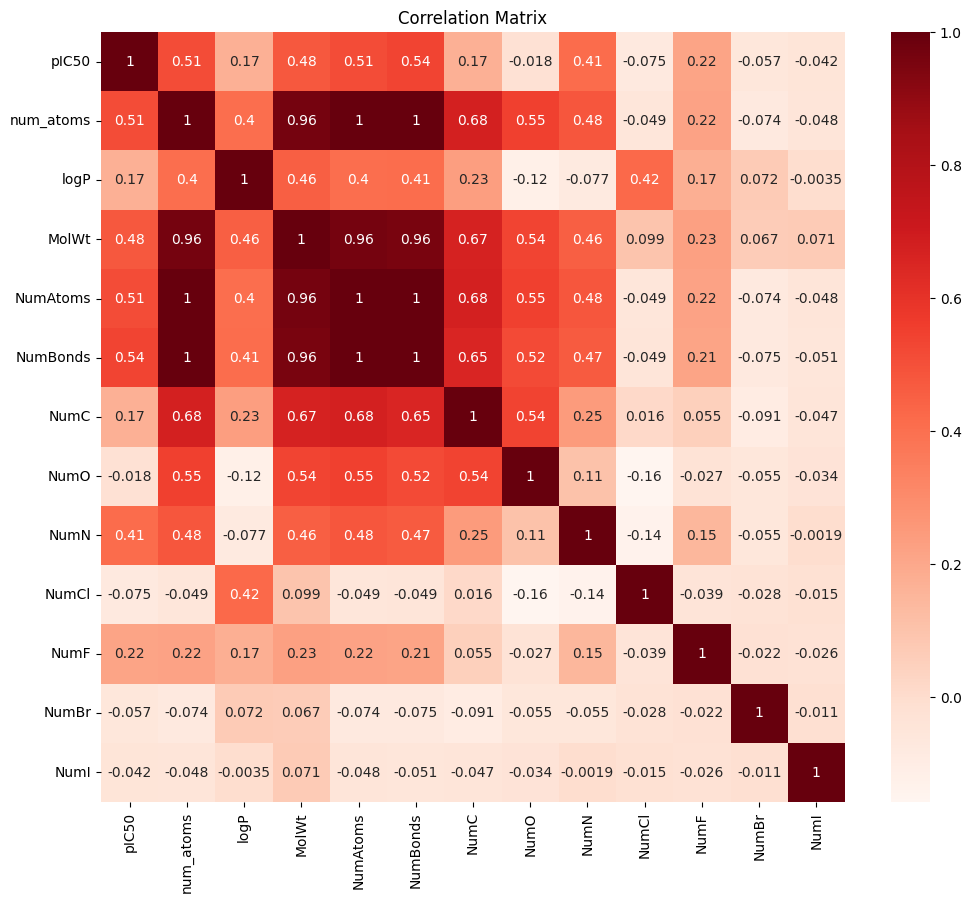

In [6]:
# Feature visualization
plot_correlation_matrix(data_with_features)

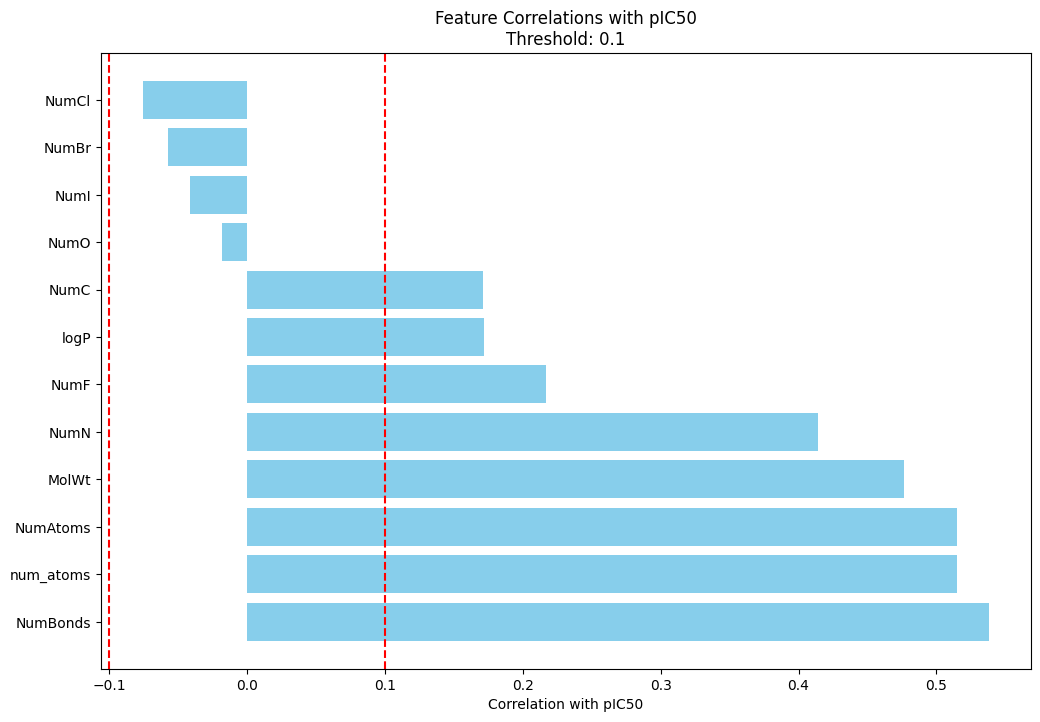

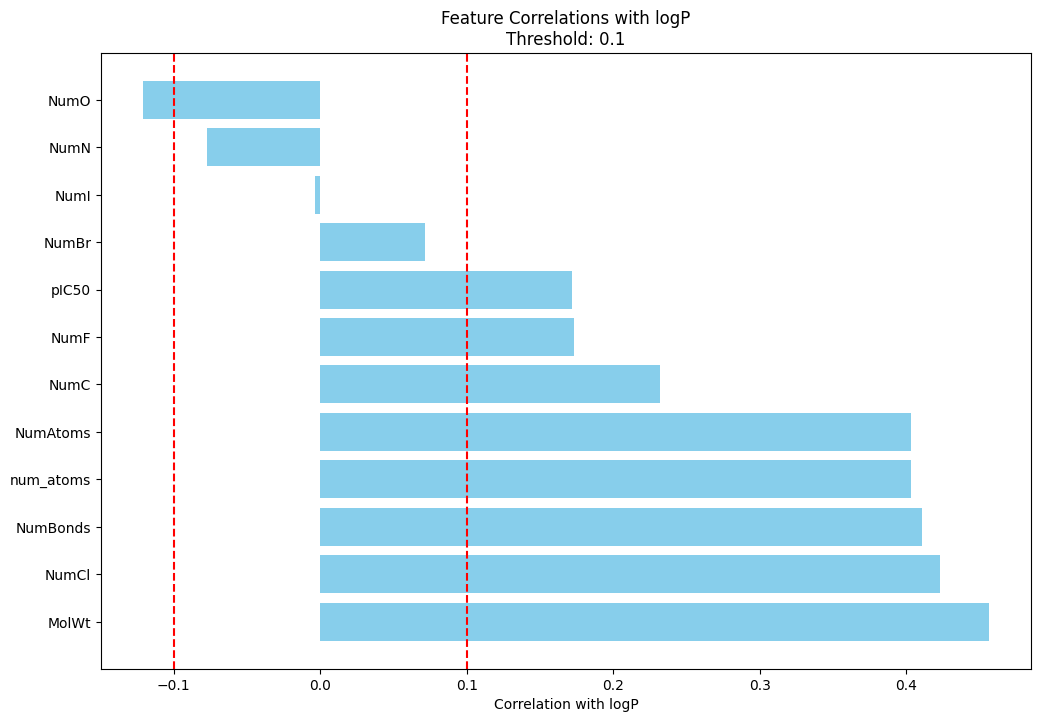

In [7]:
# Plot feature correlations with pIC50 and logP
plot_feature_correlations(data_with_features, 'pIC50', output_path="feature_correlations_pic50.png")
plot_feature_correlations(data_with_features, 'logP', output_path="feature_correlations_logP.png")

[I 2024-06-05 16:34:00,750] A new study created in memory with name: no-name-4bc06647-e4e2-4d9b-b9a2-c68597b52f93


Hyperparameter Tuning (Neural Network):   0%|          | 0/50 [00:00<?, ?it/s]

Training Epochs (75):   0%|          | 0/75 [00:00<?, ?it/s]

[I 2024-06-05 16:34:28,949] Trial 0 finished with value: 2.1990057535287812 and parameters: {'lr': 1.1535103379638043e-05, 'epochs': 75, 'batch_size': 60, 'hidden_layers': 3, 'hidden_size_0': 76, 'hidden_size_1': 203, 'hidden_size_2': 195, 'patience': 6}. Best is trial 0 with value: 2.1990057535287812.


Training Epochs (43):   0%|          | 0/43 [00:00<?, ?it/s]

[I 2024-06-05 16:34:57,934] Trial 1 finished with value: 1.6130829469491077 and parameters: {'lr': 7.84688879034726e-05, 'epochs': 43, 'batch_size': 26, 'hidden_layers': 3, 'hidden_size_0': 57, 'hidden_size_1': 148, 'hidden_size_2': 232, 'patience': 8}. Best is trial 1 with value: 1.6130829469491077.


Training Epochs (28):   0%|          | 0/28 [00:00<?, ?it/s]

[I 2024-06-05 16:35:07,169] Trial 2 finished with value: 1.0923460414633155 and parameters: {'lr': 0.0009535943782626434, 'epochs': 28, 'batch_size': 76, 'hidden_layers': 3, 'hidden_size_0': 203, 'hidden_size_1': 103, 'hidden_size_2': 240, 'patience': 6}. Best is trial 2 with value: 1.0923460414633155.


Training Epochs (28):   0%|          | 0/28 [00:00<?, ?it/s]

[I 2024-06-05 16:35:15,160] Trial 3 finished with value: 1.8176538562774658 and parameters: {'lr': 0.08215287393836461, 'epochs': 28, 'batch_size': 98, 'hidden_layers': 3, 'hidden_size_0': 187, 'hidden_size_1': 209, 'hidden_size_2': 209, 'patience': 10}. Best is trial 2 with value: 1.0923460414633155.


Training Epochs (99):   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-06-05 16:35:37,851] Trial 4 finished with value: 1.7747041051512333 and parameters: {'lr': 0.010964629515470819, 'epochs': 99, 'batch_size': 18, 'hidden_layers': 1, 'hidden_size_0': 208, 'patience': 8}. Best is trial 2 with value: 1.0923460414633155.


Training Epochs (58):   0%|          | 0/58 [00:00<?, ?it/s]

[I 2024-06-05 16:35:50,204] Trial 5 finished with value: 2.135089554437777 and parameters: {'lr': 0.04622844991293089, 'epochs': 58, 'batch_size': 59, 'hidden_layers': 1, 'hidden_size_0': 139, 'patience': 15}. Best is trial 2 with value: 1.0923460414633155.


Training Epochs (56):   0%|          | 0/56 [00:00<?, ?it/s]

[I 2024-06-05 16:35:55,401] Trial 6 finished with value: 2.3221926245154165 and parameters: {'lr': 0.05101266421306582, 'epochs': 56, 'batch_size': 50, 'hidden_layers': 2, 'hidden_size_0': 39, 'hidden_size_1': 70, 'patience': 5}. Best is trial 2 with value: 1.0923460414633155.


Training Epochs (30):   0%|          | 0/30 [00:00<?, ?it/s]

[I 2024-06-05 16:36:08,881] Trial 7 finished with value: 2.1931908501519097 and parameters: {'lr': 1.3185752559037714e-05, 'epochs': 30, 'batch_size': 54, 'hidden_layers': 3, 'hidden_size_0': 237, 'hidden_size_1': 212, 'hidden_size_2': 250, 'patience': 10}. Best is trial 2 with value: 1.0923460414633155.


Training Epochs (86):   0%|          | 0/86 [00:00<?, ?it/s]

[I 2024-06-05 16:36:23,629] Trial 8 finished with value: 1.1024203300476074 and parameters: {'lr': 0.0018529842935149465, 'epochs': 86, 'batch_size': 79, 'hidden_layers': 3, 'hidden_size_0': 108, 'hidden_size_1': 173, 'hidden_size_2': 179, 'patience': 14}. Best is trial 2 with value: 1.0923460414633155.


Training Epochs (28):   0%|          | 0/28 [00:00<?, ?it/s]

[I 2024-06-05 16:36:29,509] Trial 9 finished with value: 1.701382542649905 and parameters: {'lr': 0.05542071062584897, 'epochs': 28, 'batch_size': 104, 'hidden_layers': 2, 'hidden_size_0': 125, 'hidden_size_1': 170, 'patience': 16}. Best is trial 2 with value: 1.0923460414633155.


Training Epochs (13):   0%|          | 0/13 [00:00<?, ?it/s]

[I 2024-06-05 16:36:31,982] Trial 10 finished with value: 1.8401443589301336 and parameters: {'lr': 0.0006083115749296893, 'epochs': 13, 'batch_size': 119, 'hidden_layers': 2, 'hidden_size_0': 180, 'hidden_size_1': 74, 'patience': 20}. Best is trial 2 with value: 1.0923460414633155.


Training Epochs (88):   0%|          | 0/88 [00:00<?, ?it/s]

[I 2024-06-05 16:36:49,484] Trial 11 finished with value: 1.1530438764341946 and parameters: {'lr': 0.0019040049489293957, 'epochs': 88, 'batch_size': 83, 'hidden_layers': 3, 'hidden_size_0': 102, 'hidden_size_1': 115, 'hidden_size_2': 103, 'patience': 14}. Best is trial 2 with value: 1.0923460414633155.


Training Epochs (77):   0%|          | 0/77 [00:00<?, ?it/s]

[I 2024-06-05 16:37:02,705] Trial 12 finished with value: 1.0951754849018722 and parameters: {'lr': 0.0010884888042767963, 'epochs': 77, 'batch_size': 83, 'hidden_layers': 3, 'hidden_size_0': 251, 'hidden_size_1': 112, 'hidden_size_2': 146, 'patience': 12}. Best is trial 2 with value: 1.0923460414633155.


Training Epochs (75):   0%|          | 0/75 [00:00<?, ?it/s]

[I 2024-06-05 16:37:19,659] Trial 13 finished with value: 1.3559322633125164 and parameters: {'lr': 0.00038249278337957064, 'epochs': 75, 'batch_size': 92, 'hidden_layers': 2, 'hidden_size_0': 255, 'hidden_size_1': 32, 'patience': 19}. Best is trial 2 with value: 1.0923460414633155.


Training Epochs (65):   0%|          | 0/65 [00:00<?, ?it/s]

[I 2024-06-05 16:37:26,855] Trial 14 finished with value: 1.1892037640015285 and parameters: {'lr': 0.006575482205930132, 'epochs': 65, 'batch_size': 116, 'hidden_layers': 3, 'hidden_size_0': 214, 'hidden_size_1': 108, 'hidden_size_2': 41, 'patience': 11}. Best is trial 2 with value: 1.0923460414633155.


Training Epochs (44):   0%|          | 0/44 [00:00<?, ?it/s]

[I 2024-06-05 16:37:38,842] Trial 15 finished with value: 1.5743837391628939 and parameters: {'lr': 0.00014983199728755146, 'epochs': 44, 'batch_size': 72, 'hidden_layers': 2, 'hidden_size_0': 171, 'hidden_size_1': 253, 'patience': 7}. Best is trial 2 with value: 1.0923460414633155.


Training Epochs (42):   0%|          | 0/42 [00:00<?, ?it/s]

[I 2024-06-05 16:38:00,339] Trial 16 finished with value: 1.323034982313402 and parameters: {'lr': 0.005461217087242366, 'epochs': 42, 'batch_size': 38, 'hidden_layers': 3, 'hidden_size_0': 253, 'hidden_size_1': 110, 'hidden_size_2': 130, 'patience': 17}. Best is trial 2 with value: 1.0923460414633155.


Training Epochs (10):   0%|          | 0/10 [00:00<?, ?it/s]

[I 2024-06-05 16:38:02,359] Trial 17 finished with value: 2.7297934188562283 and parameters: {'lr': 0.00010320132682186866, 'epochs': 10, 'batch_size': 72, 'hidden_layers': 1, 'hidden_size_0': 218, 'patience': 12}. Best is trial 2 with value: 1.0923460414633155.


Training Epochs (71):   0%|          | 0/71 [00:00<?, ?it/s]

[I 2024-06-05 16:38:17,506] Trial 18 finished with value: 1.3644828757514125 and parameters: {'lr': 0.00033706922489579904, 'epochs': 71, 'batch_size': 108, 'hidden_layers': 2, 'hidden_size_0': 231, 'hidden_size_1': 75, 'patience': 9}. Best is trial 2 with value: 1.0923460414633155.


Training Epochs (20):   0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-06-05 16:38:22,808] Trial 19 finished with value: 1.2345776877232961 and parameters: {'lr': 0.001748730972657426, 'epochs': 20, 'batch_size': 86, 'hidden_layers': 3, 'hidden_size_0': 160, 'hidden_size_1': 138, 'hidden_size_2': 77, 'patience': 5}. Best is trial 2 with value: 1.0923460414633155.


Training Epochs (84):   0%|          | 0/84 [00:00<?, ?it/s]

[I 2024-06-05 16:38:38,464] Trial 20 finished with value: 2.0422728877318534 and parameters: {'lr': 5.1173492690201245e-05, 'epochs': 84, 'batch_size': 128, 'hidden_layers': 2, 'hidden_size_0': 198, 'hidden_size_1': 48, 'patience': 12}. Best is trial 2 with value: 1.0923460414633155.


Training Epochs (100):   0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-06-05 16:38:59,039] Trial 21 finished with value: 1.0552112868716639 and parameters: {'lr': 0.0014850733965971995, 'epochs': 100, 'batch_size': 79, 'hidden_layers': 3, 'hidden_size_0': 103, 'hidden_size_1': 169, 'hidden_size_2': 170, 'patience': 14}. Best is trial 21 with value: 1.0552112868716639.


Training Epochs (99):   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-06-05 16:39:18,027] Trial 22 finished with value: 1.0924881150325139 and parameters: {'lr': 0.000846567899716598, 'epochs': 99, 'batch_size': 67, 'hidden_layers': 3, 'hidden_size_0': 82, 'hidden_size_1': 128, 'hidden_size_2': 155, 'patience': 18}. Best is trial 21 with value: 1.0552112868716639.


Training Epochs (100):   0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-06-05 16:39:44,243] Trial 23 finished with value: 1.228538754670059 and parameters: {'lr': 0.00383022115087356, 'epochs': 100, 'batch_size': 71, 'hidden_layers': 3, 'hidden_size_0': 86, 'hidden_size_1': 142, 'hidden_size_2': 163, 'patience': 18}. Best is trial 21 with value: 1.0552112868716639.


Training Epochs (92):   0%|          | 0/92 [00:00<?, ?it/s]

[I 2024-06-05 16:40:19,143] Trial 24 finished with value: 1.2269369107231778 and parameters: {'lr': 0.00027741877204040907, 'epochs': 92, 'batch_size': 46, 'hidden_layers': 3, 'hidden_size_0': 72, 'hidden_size_1': 171, 'hidden_size_2': 215, 'patience': 14}. Best is trial 21 with value: 1.0552112868716639.


Training Epochs (94):   0%|          | 0/94 [00:00<?, ?it/s]

[I 2024-06-05 16:40:35,314] Trial 25 finished with value: 1.3798751458525658 and parameters: {'lr': 0.020157904790329164, 'epochs': 94, 'batch_size': 63, 'hidden_layers': 3, 'hidden_size_0': 119, 'hidden_size_1': 93, 'hidden_size_2': 124, 'patience': 17}. Best is trial 21 with value: 1.0552112868716639.


Training Epochs (65):   0%|          | 0/65 [00:00<?, ?it/s]

[I 2024-06-05 16:40:52,395] Trial 26 finished with value: 1.144369783224883 and parameters: {'lr': 0.0006976642777785262, 'epochs': 65, 'batch_size': 92, 'hidden_layers': 3, 'hidden_size_0': 152, 'hidden_size_1': 131, 'hidden_size_2': 171, 'patience': 20}. Best is trial 21 with value: 1.0552112868716639.


Training Epochs (36):   0%|          | 0/36 [00:00<?, ?it/s]

[I 2024-06-05 16:41:05,924] Trial 27 finished with value: 1.1292635266811162 and parameters: {'lr': 0.0028995603729442625, 'epochs': 36, 'batch_size': 41, 'hidden_layers': 2, 'hidden_size_0': 94, 'hidden_size_1': 163, 'patience': 16}. Best is trial 21 with value: 1.0552112868716639.


Training Epochs (83):   0%|          | 0/83 [00:00<?, ?it/s]

[I 2024-06-05 16:41:24,466] Trial 28 finished with value: 1.0613205936309453 and parameters: {'lr': 0.0010196390633218635, 'epochs': 83, 'batch_size': 66, 'hidden_layers': 3, 'hidden_size_0': 138, 'hidden_size_1': 191, 'hidden_size_2': 97, 'patience': 13}. Best is trial 21 with value: 1.0552112868716639.


Training Epochs (81):   0%|          | 0/81 [00:00<?, ?it/s]

[I 2024-06-05 16:41:45,567] Trial 29 finished with value: 1.4874167493203792 and parameters: {'lr': 0.017221283563226355, 'epochs': 81, 'batch_size': 59, 'hidden_layers': 3, 'hidden_size_0': 136, 'hidden_size_1': 194, 'hidden_size_2': 91, 'patience': 13}. Best is trial 21 with value: 1.0552112868716639.


Training Epochs (92):   0%|          | 0/92 [00:00<?, ?it/s]

[I 2024-06-05 16:42:12,095] Trial 30 finished with value: 1.0899230288341641 and parameters: {'lr': 0.00019915798365481634, 'epochs': 92, 'batch_size': 77, 'hidden_layers': 3, 'hidden_size_0': 164, 'hidden_size_1': 238, 'hidden_size_2': 58, 'patience': 13}. Best is trial 21 with value: 1.0552112868716639.


Training Epochs (92):   0%|          | 0/92 [00:00<?, ?it/s]

[I 2024-06-05 16:42:40,639] Trial 31 finished with value: 1.1446079512437184 and parameters: {'lr': 0.00016166330143909953, 'epochs': 92, 'batch_size': 74, 'hidden_layers': 3, 'hidden_size_0': 170, 'hidden_size_1': 254, 'hidden_size_2': 50, 'patience': 13}. Best is trial 21 with value: 1.0552112868716639.


Training Epochs (49):   0%|          | 0/49 [00:00<?, ?it/s]

[I 2024-06-05 16:42:54,357] Trial 32 finished with value: 1.9282510655897636 and parameters: {'lr': 4.213799629104001e-05, 'epochs': 49, 'batch_size': 90, 'hidden_layers': 3, 'hidden_size_0': 151, 'hidden_size_1': 229, 'hidden_size_2': 67, 'patience': 11}. Best is trial 21 with value: 1.0552112868716639.


Training Epochs (94):   0%|          | 0/94 [00:00<?, ?it/s]

[I 2024-06-05 16:43:10,935] Trial 33 finished with value: 1.1215107806267277 and parameters: {'lr': 0.001155511917350947, 'epochs': 94, 'batch_size': 78, 'hidden_layers': 3, 'hidden_size_0': 122, 'hidden_size_1': 228, 'hidden_size_2': 110, 'patience': 15}. Best is trial 21 with value: 1.0552112868716639.


Training Epochs (82):   0%|          | 0/82 [00:00<?, ?it/s]

[I 2024-06-05 16:43:27,735] Trial 34 finished with value: 1.064122757911682 and parameters: {'lr': 0.000496854949134628, 'epochs': 82, 'batch_size': 98, 'hidden_layers': 3, 'hidden_size_0': 191, 'hidden_size_1': 190, 'hidden_size_2': 73, 'patience': 10}. Best is trial 21 with value: 1.0552112868716639.


Training Epochs (81):   0%|          | 0/81 [00:00<?, ?it/s]

[I 2024-06-05 16:43:48,679] Trial 35 finished with value: 1.1552141606807709 and parameters: {'lr': 0.00046721472054505616, 'epochs': 81, 'batch_size': 99, 'hidden_layers': 3, 'hidden_size_0': 185, 'hidden_size_1': 191, 'hidden_size_2': 67, 'patience': 11}. Best is trial 21 with value: 1.0552112868716639.


Training Epochs (68):   0%|          | 0/68 [00:00<?, ?it/s]

[I 2024-06-05 16:44:06,388] Trial 36 finished with value: 1.4066798010697732 and parameters: {'lr': 0.00022532792377739555, 'epochs': 68, 'batch_size': 96, 'hidden_layers': 3, 'hidden_size_0': 137, 'hidden_size_1': 188, 'hidden_size_2': 82, 'patience': 9}. Best is trial 21 with value: 1.0552112868716639.


Training Epochs (89):   0%|          | 0/89 [00:00<?, ?it/s]

[I 2024-06-05 16:44:35,618] Trial 37 finished with value: 1.632637727549177 and parameters: {'lr': 2.7873182924901178e-05, 'epochs': 89, 'batch_size': 65, 'hidden_layers': 3, 'hidden_size_0': 195, 'hidden_size_1': 227, 'hidden_size_2': 34, 'patience': 10}. Best is trial 21 with value: 1.0552112868716639.


Training Epochs (78):   0%|          | 0/78 [00:00<?, ?it/s]

[I 2024-06-05 16:44:50,885] Trial 38 finished with value: 1.7487235094110172 and parameters: {'lr': 0.00014300610131920887, 'epochs': 78, 'batch_size': 104, 'hidden_layers': 2, 'hidden_size_0': 66, 'hidden_size_1': 214, 'patience': 13}. Best is trial 21 with value: 1.0552112868716639.


Training Epochs (96):   0%|          | 0/96 [00:00<?, ?it/s]

[I 2024-06-05 16:45:21,540] Trial 39 finished with value: 1.5944639236428018 and parameters: {'lr': 7.124165050909337e-05, 'epochs': 96, 'batch_size': 57, 'hidden_layers': 3, 'hidden_size_0': 40, 'hidden_size_1': 242, 'hidden_size_2': 56, 'patience': 15}. Best is trial 21 with value: 1.0552112868716639.


Training Epochs (73):   0%|          | 0/73 [00:00<?, ?it/s]

[I 2024-06-05 16:45:34,096] Trial 40 finished with value: 1.457824713417462 and parameters: {'lr': 0.002813691904351818, 'epochs': 73, 'batch_size': 86, 'hidden_layers': 1, 'hidden_size_0': 162, 'patience': 9}. Best is trial 21 with value: 1.0552112868716639.


Training Epochs (85):   0%|          | 0/85 [00:00<?, ?it/s]

[I 2024-06-05 16:45:47,263] Trial 41 finished with value: 1.120635380668025 and parameters: {'lr': 0.0005303901325301674, 'epochs': 85, 'batch_size': 78, 'hidden_layers': 3, 'hidden_size_0': 195, 'hidden_size_1': 154, 'hidden_size_2': 101, 'patience': 6}. Best is trial 21 with value: 1.0552112868716639.


Training Epochs (21):   0%|          | 0/21 [00:00<?, ?it/s]

[I 2024-06-05 16:45:53,671] Trial 42 finished with value: 1.1649625632498 and parameters: {'lr': 0.0014135224547283495, 'epochs': 21, 'batch_size': 67, 'hidden_layers': 3, 'hidden_size_0': 111, 'hidden_size_1': 179, 'hidden_size_2': 127, 'patience': 8}. Best is trial 21 with value: 1.0552112868716639.


Training Epochs (89):   0%|          | 0/89 [00:00<?, ?it/s]

[I 2024-06-05 16:46:14,088] Trial 43 finished with value: 1.130461491106285 and parameters: {'lr': 0.0007403125049334198, 'epochs': 89, 'batch_size': 54, 'hidden_layers': 3, 'hidden_size_0': 176, 'hidden_size_1': 157, 'hidden_size_2': 62, 'patience': 14}. Best is trial 21 with value: 1.0552112868716639.


Training Epochs (59):   0%|          | 0/59 [00:00<?, ?it/s]

[I 2024-06-05 16:46:32,302] Trial 44 finished with value: 1.102382451792558 and parameters: {'lr': 0.0002332655797067253, 'epochs': 59, 'batch_size': 81, 'hidden_layers': 3, 'hidden_size_0': 228, 'hidden_size_1': 201, 'hidden_size_2': 188, 'patience': 7}. Best is trial 21 with value: 1.0552112868716639.


Training Epochs (81):   0%|          | 0/81 [00:00<?, ?it/s]

[I 2024-06-05 16:46:46,184] Trial 45 finished with value: 1.2111061927862465 and parameters: {'lr': 0.0010459921909311092, 'epochs': 81, 'batch_size': 77, 'hidden_layers': 3, 'hidden_size_0': 129, 'hidden_size_1': 212, 'hidden_size_2': 85, 'patience': 11}. Best is trial 21 with value: 1.0552112868716639.


Training Epochs (52):   0%|          | 0/52 [00:00<?, ?it/s]

[I 2024-06-05 16:46:58,517] Trial 46 finished with value: 1.232387133620002 and parameters: {'lr': 0.0025258340399779166, 'epochs': 52, 'batch_size': 114, 'hidden_layers': 3, 'hidden_size_0': 201, 'hidden_size_1': 183, 'hidden_size_2': 211, 'patience': 6}. Best is trial 21 with value: 1.0552112868716639.


Training Epochs (98):   0%|          | 0/98 [00:00<?, ?it/s]

[I 2024-06-05 16:47:59,875] Trial 47 finished with value: 1.151471581526468 and parameters: {'lr': 0.0004444398928720426, 'epochs': 98, 'batch_size': 17, 'hidden_layers': 3, 'hidden_size_0': 147, 'hidden_size_1': 204, 'hidden_size_2': 233, 'patience': 15}. Best is trial 21 with value: 1.0552112868716639.


Training Epochs (89):   0%|          | 0/89 [00:00<?, ?it/s]

[I 2024-06-05 16:48:16,534] Trial 48 finished with value: 1.1267198084720544 and parameters: {'lr': 0.004364645311729801, 'epochs': 89, 'batch_size': 86, 'hidden_layers': 2, 'hidden_size_0': 210, 'hidden_size_1': 220, 'patience': 14}. Best is trial 21 with value: 1.0552112868716639.


Training Epochs (32):   0%|          | 0/32 [00:00<?, ?it/s]

[I 2024-06-05 16:48:24,977] Trial 49 finished with value: 1.2854893267154694 and parameters: {'lr': 0.008707693654630649, 'epochs': 32, 'batch_size': 99, 'hidden_layers': 3, 'hidden_size_0': 165, 'hidden_size_1': 167, 'hidden_size_2': 239, 'patience': 12}. Best is trial 21 with value: 1.0552112868716639.


Best trial for Neural Network: {'lr': 0.0014850733965971995, 'epochs': 100, 'batch_size': 79, 'hidden_layers': 3, 'hidden_size_0': 103, 'hidden_size_1': 169, 'hidden_size_2': 170, 'patience': 14}


Training Epochs (100):   0%|          | 0/100 [00:00<?, ?it/s]

Neural Network Model MSE for pIC50: 0.8404255546081735


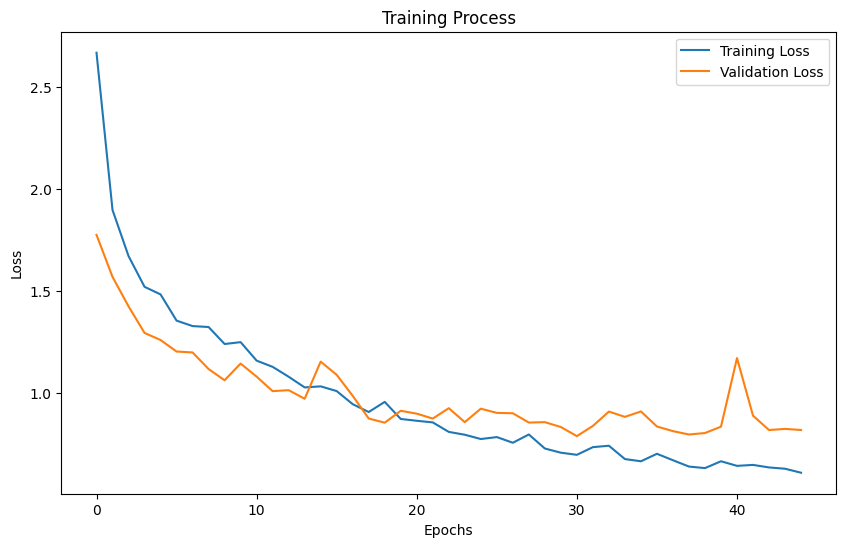

In [8]:
# Hyperparameter tuning for Neural Network (pIC50)
if model_exists('models/nn_model_pic50.pth'):
    nn_model_pic50 = NeuralNetworkModel(input_size=X_train.shape[1], hidden_sizes=[64, 32])  # Initialize with dummy sizes
    nn_model_pic50.load_model('models/nn_model_pic50.pth')
    print("Loaded existing pIC50 model.")
else:
    tuner_pic50 = HyperparameterTuning(X_train, y_train_pic50, "Neural Network")
    best_params_pic50 = tuner_pic50.tune(n_trials=50)
    nn_model_pic50 = NeuralNetworkModel(
        input_size=X_train.shape[1],
        hidden_sizes=[best_params_pic50[f"hidden_size_{i}"] for i in range(best_params_pic50["hidden_layers"])],
        lr=best_params_pic50["lr"],
        epochs=best_params_pic50["epochs"],
        batch_size=best_params_pic50["batch_size"],
        patience=best_params_pic50["patience"]
    )
    training_loss_pic50, validation_loss_pic50 = nn_model_pic50.train(X_train, y_train_pic50, X_test, y_test_pic50)
    torch.save(nn_model_pic50.model.state_dict(), 'models/nn_model_pic50.pth')
    print(f"Neural Network Model MSE for pIC50: {nn_model_pic50.evaluate(X_test, y_test_pic50)}")
    plot_training_process(training_loss_pic50, validation_loss_pic50, output_path="training_process_pic50.png")


[I 2024-06-05 16:48:40,958] A new study created in memory with name: no-name-9b2e151c-86de-4d08-acaf-e5c46d3983fe


Hyperparameter Tuning (Neural Network):   0%|          | 0/50 [00:00<?, ?it/s]

Training Epochs (22):   0%|          | 0/22 [00:00<?, ?it/s]

[I 2024-06-05 16:48:50,817] Trial 0 finished with value: 0.503201560013824 and parameters: {'lr': 0.006719177013817551, 'epochs': 22, 'batch_size': 27, 'hidden_layers': 2, 'hidden_size_0': 37, 'hidden_size_1': 187, 'patience': 12}. Best is trial 0 with value: 0.503201560013824.


Training Epochs (61):   0%|          | 0/61 [00:00<?, ?it/s]

[I 2024-06-05 16:49:36,384] Trial 1 finished with value: 0.6389440283179283 and parameters: {'lr': 1.115511738803195e-05, 'epochs': 61, 'batch_size': 22, 'hidden_layers': 3, 'hidden_size_0': 83, 'hidden_size_1': 210, 'hidden_size_2': 146, 'patience': 7}. Best is trial 0 with value: 0.503201560013824.


Training Epochs (45):   0%|          | 0/45 [00:00<?, ?it/s]

[I 2024-06-05 16:49:45,999] Trial 2 finished with value: 0.5443533776622069 and parameters: {'lr': 0.002450054512786517, 'epochs': 45, 'batch_size': 64, 'hidden_layers': 1, 'hidden_size_0': 182, 'patience': 13}. Best is trial 0 with value: 0.503201560013824.


Training Epochs (53):   0%|          | 0/53 [00:00<?, ?it/s]

[I 2024-06-05 16:49:54,877] Trial 3 finished with value: 0.6319149537728384 and parameters: {'lr': 0.0002826238645484505, 'epochs': 53, 'batch_size': 93, 'hidden_layers': 1, 'hidden_size_0': 96, 'patience': 13}. Best is trial 0 with value: 0.503201560013824.


Training Epochs (83):   0%|          | 0/83 [00:00<?, ?it/s]

[I 2024-06-05 16:50:24,598] Trial 4 finished with value: 0.4661785601860001 and parameters: {'lr': 0.00021963993391402098, 'epochs': 83, 'batch_size': 58, 'hidden_layers': 3, 'hidden_size_0': 194, 'hidden_size_1': 173, 'hidden_size_2': 169, 'patience': 10}. Best is trial 4 with value: 0.4661785601860001.


Training Epochs (17):   0%|          | 0/17 [00:00<?, ?it/s]

[I 2024-06-05 16:50:30,967] Trial 5 finished with value: 0.5797231440903038 and parameters: {'lr': 0.002310195472267197, 'epochs': 17, 'batch_size': 26, 'hidden_layers': 1, 'hidden_size_0': 32, 'patience': 5}. Best is trial 4 with value: 0.4661785601860001.


Training Epochs (76):   0%|          | 0/76 [00:00<?, ?it/s]

[I 2024-06-05 16:50:51,712] Trial 6 finished with value: 0.8095746607549729 and parameters: {'lr': 1.1631881908127481e-05, 'epochs': 76, 'batch_size': 39, 'hidden_layers': 1, 'hidden_size_0': 140, 'patience': 11}. Best is trial 4 with value: 0.4661785601860001.


Training Epochs (78):   0%|          | 0/78 [00:00<?, ?it/s]

[I 2024-06-05 16:51:09,249] Trial 7 finished with value: 0.5553400446971257 and parameters: {'lr': 0.04351928743205245, 'epochs': 78, 'batch_size': 82, 'hidden_layers': 2, 'hidden_size_0': 233, 'hidden_size_1': 119, 'patience': 16}. Best is trial 4 with value: 0.4661785601860001.


Training Epochs (35):   0%|          | 0/35 [00:00<?, ?it/s]

[I 2024-06-05 16:51:18,488] Trial 8 finished with value: 0.5266293281955379 and parameters: {'lr': 0.0015344713748656252, 'epochs': 35, 'batch_size': 43, 'hidden_layers': 1, 'hidden_size_0': 169, 'patience': 8}. Best is trial 4 with value: 0.4661785601860001.


Training Epochs (68):   0%|          | 0/68 [00:00<?, ?it/s]

[I 2024-06-05 16:51:30,969] Trial 9 finished with value: 0.7082757496833801 and parameters: {'lr': 3.276270423234367e-05, 'epochs': 68, 'batch_size': 99, 'hidden_layers': 2, 'hidden_size_0': 55, 'hidden_size_1': 110, 'patience': 15}. Best is trial 4 with value: 0.4661785601860001.


Training Epochs (100):   0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-06-05 16:51:51,106] Trial 10 finished with value: 0.507806807756424 and parameters: {'lr': 0.0001342766608171511, 'epochs': 100, 'batch_size': 128, 'hidden_layers': 3, 'hidden_size_0': 251, 'hidden_size_1': 36, 'hidden_size_2': 253, 'patience': 20}. Best is trial 4 with value: 0.4661785601860001.


Training Epochs (10):   0%|          | 0/10 [00:00<?, ?it/s]

[I 2024-06-05 16:51:54,731] Trial 11 finished with value: 0.6628687272711498 and parameters: {'lr': 0.020351492492752515, 'epochs': 10, 'batch_size': 59, 'hidden_layers': 3, 'hidden_size_0': 203, 'hidden_size_1': 205, 'hidden_size_2': 128, 'patience': 10}. Best is trial 4 with value: 0.4661785601860001.


Training Epochs (93):   0%|          | 0/93 [00:00<?, ?it/s]

[I 2024-06-05 16:52:07,011] Trial 12 finished with value: 0.4866186219912309 and parameters: {'lr': 0.01145765160254694, 'epochs': 93, 'batch_size': 47, 'hidden_layers': 2, 'hidden_size_0': 128, 'hidden_size_1': 169, 'patience': 9}. Best is trial 4 with value: 0.4661785601860001.


Training Epochs (100):   0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-06-05 16:52:45,191] Trial 13 finished with value: 0.44644629103796823 and parameters: {'lr': 0.0002722113556952073, 'epochs': 100, 'batch_size': 50, 'hidden_layers': 3, 'hidden_size_0': 131, 'hidden_size_1': 159, 'hidden_size_2': 205, 'patience': 9}. Best is trial 13 with value: 0.44644629103796823.


Training Epochs (86):   0%|          | 0/86 [00:00<?, ?it/s]

[I 2024-06-05 16:53:05,633] Trial 14 finished with value: 0.4656327890627312 and parameters: {'lr': 0.0002973132003755962, 'epochs': 86, 'batch_size': 73, 'hidden_layers': 3, 'hidden_size_0': 207, 'hidden_size_1': 244, 'hidden_size_2': 207, 'patience': 6}. Best is trial 13 with value: 0.44644629103796823.


Training Epochs (91):   0%|          | 0/91 [00:00<?, ?it/s]

[I 2024-06-05 16:53:16,473] Trial 15 finished with value: 0.482408922504295 and parameters: {'lr': 0.0004497260659120857, 'epochs': 91, 'batch_size': 75, 'hidden_layers': 3, 'hidden_size_0': 114, 'hidden_size_1': 251, 'hidden_size_2': 234, 'patience': 5}. Best is trial 13 with value: 0.44644629103796823.


Training Epochs (88):   0%|          | 0/88 [00:00<?, ?it/s]

[I 2024-06-05 16:53:39,185] Trial 16 finished with value: 0.5167513139869856 and parameters: {'lr': 7.076824019527746e-05, 'epochs': 88, 'batch_size': 106, 'hidden_layers': 3, 'hidden_size_0': 158, 'hidden_size_1': 254, 'hidden_size_2': 196, 'patience': 7}. Best is trial 13 with value: 0.44644629103796823.


Training Epochs (71):   0%|          | 0/71 [00:00<?, ?it/s]

[I 2024-06-05 16:53:52,064] Trial 17 finished with value: 0.5041374605277489 and parameters: {'lr': 0.0006414566755327895, 'epochs': 71, 'batch_size': 83, 'hidden_layers': 3, 'hidden_size_0': 218, 'hidden_size_1': 81, 'hidden_size_2': 59, 'patience': 6}. Best is trial 13 with value: 0.44644629103796823.


Training Epochs (100):   0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-06-05 16:54:22,245] Trial 18 finished with value: 0.5409213763972124 and parameters: {'lr': 5.2476596297191214e-05, 'epochs': 100, 'batch_size': 51, 'hidden_layers': 2, 'hidden_size_0': 152, 'hidden_size_1': 137, 'patience': 8}. Best is trial 13 with value: 0.44644629103796823.


Training Epochs (61):   0%|          | 0/61 [00:00<?, ?it/s]

[I 2024-06-05 16:54:42,879] Trial 19 finished with value: 0.43327900932894814 and parameters: {'lr': 0.0006744575173449947, 'epochs': 61, 'batch_size': 68, 'hidden_layers': 3, 'hidden_size_0': 107, 'hidden_size_1': 216, 'hidden_size_2': 198, 'patience': 15}. Best is trial 19 with value: 0.43327900932894814.


Training Epochs (37):   0%|          | 0/37 [00:00<?, ?it/s]

[I 2024-06-05 16:54:52,766] Trial 20 finished with value: 0.47519688379196895 and parameters: {'lr': 0.0008132612011814214, 'epochs': 37, 'batch_size': 115, 'hidden_layers': 3, 'hidden_size_0': 77, 'hidden_size_1': 214, 'hidden_size_2': 196, 'patience': 17}. Best is trial 19 with value: 0.43327900932894814.


Training Epochs (58):   0%|          | 0/58 [00:00<?, ?it/s]

[I 2024-06-05 16:55:13,475] Trial 21 finished with value: 0.5101637338337145 and parameters: {'lr': 0.00014088226208192026, 'epochs': 58, 'batch_size': 64, 'hidden_layers': 3, 'hidden_size_0': 114, 'hidden_size_1': 230, 'hidden_size_2': 212, 'patience': 15}. Best is trial 19 with value: 0.43327900932894814.


Training Epochs (84):   0%|          | 0/84 [00:00<?, ?it/s]

[I 2024-06-05 16:55:38,612] Trial 22 finished with value: 0.39202625462503143 and parameters: {'lr': 0.004234060236529901, 'epochs': 84, 'batch_size': 74, 'hidden_layers': 3, 'hidden_size_0': 120, 'hidden_size_1': 233, 'hidden_size_2': 175, 'patience': 18}. Best is trial 22 with value: 0.39202625462503143.


Training Epochs (71):   0%|          | 0/71 [00:00<?, ?it/s]

[I 2024-06-05 16:55:53,482] Trial 23 finished with value: 0.4511388742497989 and parameters: {'lr': 0.004868458147059117, 'epochs': 71, 'batch_size': 86, 'hidden_layers': 2, 'hidden_size_0': 105, 'hidden_size_1': 161, 'patience': 20}. Best is trial 22 with value: 0.39202625462503143.


Training Epochs (93):   0%|          | 0/93 [00:00<?, ?it/s]

[I 2024-06-05 16:56:41,221] Trial 24 finished with value: 0.4083839720242644 and parameters: {'lr': 0.0010427898770144356, 'epochs': 93, 'batch_size': 33, 'hidden_layers': 3, 'hidden_size_0': 136, 'hidden_size_1': 188, 'hidden_size_2': 166, 'patience': 17}. Best is trial 22 with value: 0.39202625462503143.


Training Epochs (79):   0%|          | 0/79 [00:00<?, ?it/s]

[I 2024-06-05 16:57:18,724] Trial 25 finished with value: 0.42183148817739624 and parameters: {'lr': 0.003992808232921381, 'epochs': 79, 'batch_size': 35, 'hidden_layers': 3, 'hidden_size_0': 75, 'hidden_size_1': 202, 'hidden_size_2': 123, 'patience': 18}. Best is trial 22 with value: 0.39202625462503143.


Training Epochs (81):   0%|          | 0/81 [00:00<?, ?it/s]

[I 2024-06-05 16:57:27,323] Trial 26 finished with value: 2.039509121215705 and parameters: {'lr': 0.09038656728455836, 'epochs': 81, 'batch_size': 37, 'hidden_layers': 2, 'hidden_size_0': 72, 'hidden_size_1': 192, 'patience': 18}. Best is trial 22 with value: 0.39202625462503143.


Training Epochs (91):   0%|          | 0/91 [00:00<?, ?it/s]

[I 2024-06-05 16:58:41,582] Trial 27 finished with value: 0.44090954559062845 and parameters: {'lr': 0.003409984208487753, 'epochs': 91, 'batch_size': 18, 'hidden_layers': 3, 'hidden_size_0': 61, 'hidden_size_1': 225, 'hidden_size_2': 101, 'patience': 18}. Best is trial 22 with value: 0.39202625462503143.


Training Epochs (67):   0%|          | 0/67 [00:00<?, ?it/s]

[I 2024-06-05 16:59:13,093] Trial 28 finished with value: 0.5275209381960441 and parameters: {'lr': 0.016109097372371966, 'epochs': 67, 'batch_size': 35, 'hidden_layers': 3, 'hidden_size_0': 90, 'hidden_size_1': 188, 'hidden_size_2': 109, 'patience': 19}. Best is trial 22 with value: 0.39202625462503143.


Training Epochs (78):   0%|          | 0/78 [00:00<?, ?it/s]

[I 2024-06-05 16:59:45,152] Trial 29 finished with value: 0.44892891668356383 and parameters: {'lr': 0.006821689733376168, 'epochs': 78, 'batch_size': 31, 'hidden_layers': 2, 'hidden_size_0': 56, 'hidden_size_1': 236, 'patience': 17}. Best is trial 22 with value: 0.39202625462503143.


Training Epochs (93):   0%|          | 0/93 [00:00<?, ?it/s]

[I 2024-06-05 17:01:10,266] Trial 30 finished with value: 0.3527068356607134 and parameters: {'lr': 0.0012221958959582903, 'epochs': 93, 'batch_size': 16, 'hidden_layers': 3, 'hidden_size_0': 130, 'hidden_size_1': 146, 'hidden_size_2': 160, 'patience': 19}. Best is trial 30 with value: 0.3527068356607134.


Training Epochs (94):   0%|          | 0/94 [00:00<?, ?it/s]

[I 2024-06-05 17:02:35,897] Trial 31 finished with value: 0.37391385290500345 and parameters: {'lr': 0.0014959077410105737, 'epochs': 94, 'batch_size': 16, 'hidden_layers': 3, 'hidden_size_0': 126, 'hidden_size_1': 126, 'hidden_size_2': 153, 'patience': 19}. Best is trial 30 with value: 0.3527068356607134.


Training Epochs (95):   0%|          | 0/95 [00:00<?, ?it/s]

[I 2024-06-05 17:03:48,110] Trial 32 finished with value: 0.4040874874028634 and parameters: {'lr': 0.0014756733536214822, 'epochs': 95, 'batch_size': 19, 'hidden_layers': 3, 'hidden_size_0': 131, 'hidden_size_1': 137, 'hidden_size_2': 162, 'patience': 19}. Best is trial 30 with value: 0.3527068356607134.


Training Epochs (95):   0%|          | 0/95 [00:00<?, ?it/s]

[I 2024-06-05 17:04:59,920] Trial 33 finished with value: 0.3581986533492569 and parameters: {'lr': 0.0014444140122262933, 'epochs': 95, 'batch_size': 19, 'hidden_layers': 3, 'hidden_size_0': 123, 'hidden_size_1': 92, 'hidden_size_2': 164, 'patience': 19}. Best is trial 30 with value: 0.3527068356607134.


Training Epochs (86):   0%|          | 0/86 [00:00<?, ?it/s]

[I 2024-06-05 17:06:15,145] Trial 34 finished with value: 0.47337717557979736 and parameters: {'lr': 0.007525513936122119, 'epochs': 86, 'batch_size': 16, 'hidden_layers': 3, 'hidden_size_0': 169, 'hidden_size_1': 75, 'hidden_size_2': 148, 'patience': 19}. Best is trial 30 with value: 0.3527068356607134.


Training Epochs (95):   0%|          | 0/95 [00:00<?, ?it/s]

[I 2024-06-05 17:07:12,078] Trial 35 finished with value: 0.37700342563624234 and parameters: {'lr': 0.0022404992327256508, 'epochs': 95, 'batch_size': 25, 'hidden_layers': 3, 'hidden_size_0': 120, 'hidden_size_1': 100, 'hidden_size_2': 175, 'patience': 20}. Best is trial 30 with value: 0.3527068356607134.


Training Epochs (97):   0%|          | 0/97 [00:00<?, ?it/s]

[I 2024-06-05 17:08:11,326] Trial 36 finished with value: 0.37867577635135846 and parameters: {'lr': 0.0019385717876027851, 'epochs': 97, 'batch_size': 25, 'hidden_layers': 3, 'hidden_size_0': 149, 'hidden_size_1': 95, 'hidden_size_2': 182, 'patience': 20}. Best is trial 30 with value: 0.3527068356607134.


Training Epochs (89):   0%|          | 0/89 [00:00<?, ?it/s]

[I 2024-06-05 17:09:00,269] Trial 37 finished with value: 0.40579158724239556 and parameters: {'lr': 0.0012546476877610627, 'epochs': 89, 'batch_size': 24, 'hidden_layers': 3, 'hidden_size_0': 97, 'hidden_size_1': 56, 'hidden_size_2': 136, 'patience': 16}. Best is trial 30 with value: 0.3527068356607134.


Training Epochs (47):   0%|          | 0/47 [00:00<?, ?it/s]

[I 2024-06-05 17:09:21,658] Trial 38 finished with value: 0.46598649822002236 and parameters: {'lr': 0.00235468636042918, 'epochs': 47, 'batch_size': 28, 'hidden_layers': 2, 'hidden_size_0': 165, 'hidden_size_1': 120, 'patience': 20}. Best is trial 30 with value: 0.3527068356607134.


Training Epochs (74):   0%|          | 0/74 [00:00<?, ?it/s]

[I 2024-06-05 17:10:28,189] Trial 39 finished with value: 0.4050385934479584 and parameters: {'lr': 0.00042728166612045703, 'epochs': 74, 'batch_size': 16, 'hidden_layers': 3, 'hidden_size_0': 185, 'hidden_size_1': 107, 'hidden_size_2': 149, 'patience': 13}. Best is trial 30 with value: 0.3527068356607134.


Training Epochs (96):   0%|          | 0/96 [00:00<?, ?it/s]

[I 2024-06-05 17:11:18,162] Trial 40 finished with value: 0.42158419894320626 and parameters: {'lr': 0.0030818319821803775, 'epochs': 96, 'batch_size': 23, 'hidden_layers': 2, 'hidden_size_0': 146, 'hidden_size_1': 88, 'patience': 19}. Best is trial 30 with value: 0.3527068356607134.


Training Epochs (97):   0%|          | 0/97 [00:00<?, ?it/s]

[I 2024-06-05 17:12:19,338] Trial 41 finished with value: 0.3854470633634246 and parameters: {'lr': 0.001886806449825035, 'epochs': 97, 'batch_size': 24, 'hidden_layers': 3, 'hidden_size_0': 144, 'hidden_size_1': 91, 'hidden_size_2': 181, 'patience': 20}. Best is trial 30 with value: 0.3527068356607134.


Training Epochs (82):   0%|          | 0/82 [00:00<?, ?it/s]

[I 2024-06-05 17:13:04,481] Trial 42 finished with value: 0.3965103874026343 and parameters: {'lr': 0.0011261731329629925, 'epochs': 82, 'batch_size': 28, 'hidden_layers': 3, 'hidden_size_0': 123, 'hidden_size_1': 99, 'hidden_size_2': 183, 'patience': 19}. Best is trial 30 with value: 0.3527068356607134.


Training Epochs (89):   0%|          | 0/89 [00:00<?, ?it/s]

[I 2024-06-05 17:14:03,713] Trial 43 finished with value: 0.3866106884820121 and parameters: {'lr': 0.0024260360951476275, 'epochs': 89, 'batch_size': 23, 'hidden_layers': 3, 'hidden_size_0': 158, 'hidden_size_1': 123, 'hidden_size_2': 159, 'patience': 20}. Best is trial 30 with value: 0.3527068356607134.


Training Epochs (94):   0%|          | 0/94 [00:00<?, ?it/s]

[I 2024-06-05 17:14:45,017] Trial 44 finished with value: 0.44034477206597844 and parameters: {'lr': 0.0006036183865892037, 'epochs': 94, 'batch_size': 29, 'hidden_layers': 3, 'hidden_size_0': 99, 'hidden_size_1': 68, 'hidden_size_2': 184, 'patience': 16}. Best is trial 30 with value: 0.3527068356607134.


Training Epochs (29):   0%|          | 0/29 [00:00<?, ?it/s]

[I 2024-06-05 17:14:52,536] Trial 45 finished with value: 0.585026158341046 and parameters: {'lr': 0.009710029003079828, 'epochs': 29, 'batch_size': 42, 'hidden_layers': 1, 'hidden_size_0': 183, 'patience': 18}. Best is trial 30 with value: 0.3527068356607134.


Training Epochs (98):   0%|          | 0/98 [00:00<?, ?it/s]

[I 2024-06-05 17:15:56,912] Trial 46 finished with value: 0.3922529827711011 and parameters: {'lr': 0.0017001422440270986, 'epochs': 98, 'batch_size': 20, 'hidden_layers': 3, 'hidden_size_0': 143, 'hidden_size_1': 144, 'hidden_size_2': 157, 'patience': 12}. Best is trial 30 with value: 0.3527068356607134.


Training Epochs (84):   0%|          | 0/84 [00:00<?, ?it/s]

[I 2024-06-05 17:16:30,493] Trial 47 finished with value: 0.4271898605560852 and parameters: {'lr': 0.00040940820169510533, 'epochs': 84, 'batch_size': 41, 'hidden_layers': 3, 'hidden_size_0': 116, 'hidden_size_1': 108, 'hidden_size_2': 142, 'patience': 19}. Best is trial 30 with value: 0.3527068356607134.


Training Epochs (93):   0%|          | 0/93 [00:00<?, ?it/s]

[I 2024-06-05 17:17:13,713] Trial 48 finished with value: 0.4874603576385058 and parameters: {'lr': 0.0001742905675851285, 'epochs': 93, 'batch_size': 31, 'hidden_layers': 3, 'hidden_size_0': 88, 'hidden_size_1': 56, 'hidden_size_2': 116, 'patience': 20}. Best is trial 30 with value: 0.3527068356607134.


Training Epochs (100):   0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-06-05 17:17:49,112] Trial 49 finished with value: 0.39127175708611805 and parameters: {'lr': 0.0009496486615535952, 'epochs': 100, 'batch_size': 54, 'hidden_layers': 3, 'hidden_size_0': 135, 'hidden_size_1': 133, 'hidden_size_2': 221, 'patience': 17}. Best is trial 30 with value: 0.3527068356607134.


Best trial for Neural Network: {'lr': 0.0012221958959582903, 'epochs': 93, 'batch_size': 16, 'hidden_layers': 3, 'hidden_size_0': 130, 'hidden_size_1': 146, 'hidden_size_2': 160, 'patience': 19}


Training Epochs (93):   0%|          | 0/93 [00:00<?, ?it/s]

Neural Network Model MSE for logP: 0.33910915325394264


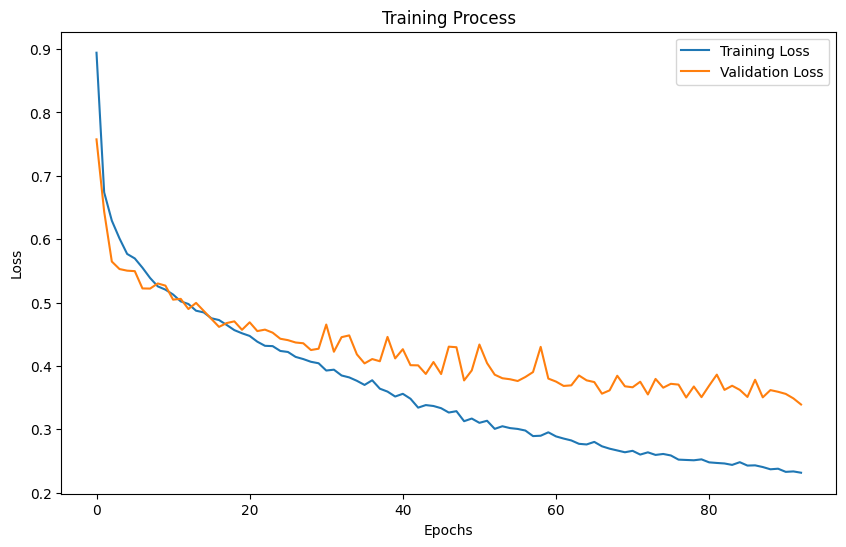

In [9]:
# Hyperparameter tuning for Neural Network (logP)
if model_exists('models/nn_model_logP.pth'):
    nn_model_logP = NeuralNetworkModel(input_size=X_train.shape[1], hidden_sizes=[64, 32])  # Initialize with dummy sizes
    nn_model_logP.load_model('models/nn_model_logP.pth')
    print("Loaded existing logP model.")
else:
    tuner_logP = HyperparameterTuning(X_train, y_train_logP, "Neural Network")
    best_params_logP = tuner_logP.tune(n_trials=50)
    nn_model_logP = NeuralNetworkModel(
        input_size=X_train.shape[1],
        hidden_sizes=[best_params_logP[f"hidden_size_{i}"] for i in range(best_params_logP["hidden_layers"])],
        lr=best_params_logP["lr"],
        epochs=best_params_logP["epochs"],
        batch_size=best_params_logP["batch_size"],
        patience=best_params_logP["patience"]
    )
    training_loss_logP, validation_loss_logP = nn_model_logP.train(X_train, y_train_logP, X_test, y_test_logP)
    torch.save(nn_model_logP.model.state_dict(), 'models/nn_model_logP.pth')
    print(f"Neural Network Model MSE for logP: {nn_model_logP.evaluate(X_test, y_test_logP)}")
    plot_training_process(training_loss_logP, validation_loss_logP, output_path="training_process_logP.png")


In [10]:
# Hyperparameter tuning and model training for KNN (pIC50)
if model_exists('models/knn_model_pic50.pkl'):
    knn_model_pic50 = joblib.load('models/knn_model_pic50.pkl')
    print("Loaded existing pIC50 KNN model.")
else:
    tuner_pic50_knn = HyperparameterTuning(X_train, y_train_pic50, "KNN")
    best_params_pic50_knn = tuner_pic50_knn.tune(n_trials=50)
    knn_model_pic50 = BaselineKNN(n_neighbors=best_params_pic50_knn["n_neighbors"])
    knn_model_pic50.train(X_train, y_train_pic50)
    joblib.dump(knn_model_pic50, 'models/knn_model_pic50.pkl')
    print(f"KNN Model MSE for pIC50: {knn_model_pic50.evaluate(X_test, y_test_pic50)}")


[I 2024-06-05 17:19:36,094] A new study created in memory with name: no-name-f67709d0-8a46-4ad1-a5c3-93834881913c


Hyperparameter Tuning (KNN):   0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-06-05 17:19:36,200] Trial 0 finished with value: 2.413099998402769 and parameters: {'n_neighbors': 6}. Best is trial 0 with value: 2.413099998402769.
[I 2024-06-05 17:19:36,322] Trial 1 finished with value: 2.8384806917987646 and parameters: {'n_neighbors': 26}. Best is trial 0 with value: 2.413099998402769.
[I 2024-06-05 17:19:36,406] Trial 2 finished with value: 2.3795294642522684 and parameters: {'n_neighbors': 5}. Best is trial 2 with value: 2.3795294642522684.
[I 2024-06-05 17:19:36,533] Trial 3 finished with value: 2.8679932012152847 and parameters: {'n_neighbors': 29}. Best is trial 2 with value: 2.3795294642522684.
[I 2024-06-05 17:19:36,631] Trial 4 finished with value: 2.6357489019837286 and parameters: {'n_neighbors': 14}. Best is trial 2 with value: 2.3795294642522684.
[I 2024-06-05 17:19:36,724] Trial 5 finished with value: 2.4539044152737444 and parameters: {'n_neighbors': 9}. Best is trial 2 with value: 2.3795294642522684.
[I 2024-06-05 17:19:36,848] Trial 6 fini

Best trial for KNN: {'n_neighbors': 3}
KNN Model MSE for pIC50: 1.7438015070921988


In [11]:
# Hyperparameter tuning and model training for KNN (logP)
if model_exists('models/knn_model_logP.pkl'):
    knn_model_logP = joblib.load('models/knn_model_logP.pkl')
    print("Loaded existing logP KNN model.")
else:
    tuner_logP_knn = HyperparameterTuning(X_train, y_train_logP, "KNN")
    best_params_logP_knn = tuner_logP_knn.tune(n_trials=50)
    knn_model_logP = BaselineKNN(n_neighbors=best_params_logP_knn["n_neighbors"])
    knn_model_logP.train(X_train, y_train_logP)
    joblib.dump(knn_model_logP, 'models/knn_model_logP.pkl')
    print(f"KNN Model MSE for logP: {knn_model_logP.evaluate(X_test, y_test_logP)}")

[I 2024-06-05 17:19:40,923] A new study created in memory with name: no-name-56c1dc46-2bd6-41b1-b5f1-03f6a85cd989


Hyperparameter Tuning (KNN):   0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-06-05 17:19:41,007] Trial 0 finished with value: 1.1126155153514925 and parameters: {'n_neighbors': 1}. Best is trial 0 with value: 1.1126155153514925.
[I 2024-06-05 17:19:41,127] Trial 1 finished with value: 1.1546031506048549 and parameters: {'n_neighbors': 21}. Best is trial 0 with value: 1.1126155153514925.
[I 2024-06-05 17:19:41,255] Trial 2 finished with value: 1.2276263546305721 and parameters: {'n_neighbors': 29}. Best is trial 0 with value: 1.1126155153514925.
[I 2024-06-05 17:19:41,369] Trial 3 finished with value: 1.144449723224965 and parameters: {'n_neighbors': 20}. Best is trial 0 with value: 1.1126155153514925.
[I 2024-06-05 17:19:41,478] Trial 4 finished with value: 0.97212624252438 and parameters: {'n_neighbors': 2}. Best is trial 4 with value: 0.97212624252438.
[I 2024-06-05 17:19:41,581] Trial 5 finished with value: 0.9934813214859163 and parameters: {'n_neighbors': 9}. Best is trial 4 with value: 0.97212624252438.
[I 2024-06-05 17:19:41,669] Trial 6 finished

Best trial for KNN: {'n_neighbors': 4}
KNN Model MSE for logP: 0.7275619698566268


In [22]:
# Hyperparameter tuning and model training for Random Forest (pIC50)
if model_exists('models/rf_model_pic50.pkl'):
    rf_model_pic50 = joblib.load('models/rf_model_pic50.pkl')
    print("Loaded existing pIC50 Random Forest model.")
else:
    tuner_pic50_rf = HyperparameterTuning(X_train, y_train_pic50, "Random Forest")
    best_params_pic50_rf = tuner_pic50_rf.tune(n_trials=50)
    rf_model_pic50 = RandomForestModel(n_estimators=best_params_pic50_rf["n_estimators"], max_depth=best_params_pic50_rf["max_depth"])
    rf_model_pic50.train(X_train, y_train_pic50)
    joblib.dump(rf_model_pic50, 'models/rf_model_pic50.pkl')
    print(f"Random Forest Model MSE for pIC50: {rf_model_pic50.evaluate(X_test, y_test_pic50)}")


[I 2024-06-05 17:42:15,442] A new study created in memory with name: no-name-a4b9d804-e64f-44d3-8c4e-6828e36dcecd


Hyperparameter Tuning (Random Forest):   0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-06-05 17:42:16,697] Trial 0 finished with value: 1.7361963308974822 and parameters: {'n_estimators': 76, 'max_depth': 19}. Best is trial 0 with value: 1.7361963308974822.
[I 2024-06-05 17:42:19,710] Trial 1 finished with value: 1.7271018916034304 and parameters: {'n_estimators': 180, 'max_depth': 23}. Best is trial 1 with value: 1.7271018916034304.
[I 2024-06-05 17:42:21,038] Trial 2 finished with value: 1.7283711869366272 and parameters: {'n_estimators': 79, 'max_depth': 12}. Best is trial 1 with value: 1.7271018916034304.
[I 2024-06-05 17:42:22,475] Trial 3 finished with value: 1.7396788042535676 and parameters: {'n_estimators': 85, 'max_depth': 4}. Best is trial 1 with value: 1.7271018916034304.
[I 2024-06-05 17:42:25,628] Trial 4 finished with value: 1.7271344965287365 and parameters: {'n_estimators': 188, 'max_depth': 22}. Best is trial 1 with value: 1.7271018916034304.
[I 2024-06-05 17:42:28,853] Trial 5 finished with value: 1.7323788026084543 and parameters: {'n_estimato

Best trial for Random Forest: {'n_estimators': 141, 'max_depth': 32}
Random Forest Model MSE for pIC50: 1.623916113883415


In [23]:
# Hyperparameter tuning and model training for Random Forest (logP)
if model_exists('models/rf_model_logP.pkl'):
    rf_model_logP = joblib.load('models/rf_model_logP.pkl')
    print("Loaded existing logP Random Forest model.")
else:
    tuner_logP_rf = HyperparameterTuning(X_train, y_train_logP, "Random Forest")
    best_params_logP_rf = tuner_logP_rf.tune(n_trials=50)
    rf_model_logP = RandomForestModel(n_estimators=best_params_logP_rf["n_estimators"], max_depth=best_params_logP_rf["max_depth"])
    rf_model_logP.train(X_train, y_train_logP)
    joblib.dump(rf_model_logP, 'models/rf_model_logP.pkl')
    print(f"Random Forest Model MSE for logP: {rf_model_logP.evaluate(X_test, y_test_logP)}")


[I 2024-06-05 17:44:02,634] A new study created in memory with name: no-name-59c19883-1991-49ac-8f64-3b95411da55d


Hyperparameter Tuning (Random Forest):   0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-06-05 17:44:03,810] Trial 0 finished with value: 0.9457399505883703 and parameters: {'n_estimators': 72, 'max_depth': 21}. Best is trial 0 with value: 0.9457399505883703.
[I 2024-06-05 17:44:05,052] Trial 1 finished with value: 0.9445657271425328 and parameters: {'n_estimators': 77, 'max_depth': 5}. Best is trial 1 with value: 0.9445657271425328.
[I 2024-06-05 17:44:07,064] Trial 2 finished with value: 0.9388258701110344 and parameters: {'n_estimators': 125, 'max_depth': 22}. Best is trial 2 with value: 0.9388258701110344.
[I 2024-06-05 17:44:09,179] Trial 3 finished with value: 0.9380733389766464 and parameters: {'n_estimators': 131, 'max_depth': 32}. Best is trial 3 with value: 0.9380733389766464.
[I 2024-06-05 17:44:11,227] Trial 4 finished with value: 0.9429871444380037 and parameters: {'n_estimators': 126, 'max_depth': 11}. Best is trial 3 with value: 0.9380733389766464.
[I 2024-06-05 17:44:14,148] Trial 5 finished with value: 0.9378059127316628 and parameters: {'n_estimat

Best trial for Random Forest: {'n_estimators': 200, 'max_depth': 14}
Random Forest Model MSE for logP: 0.8806751277963479


In [26]:
# Hyperparameter tuning and model training for Gradient Boosting (pIC50)
if model_exists('models/gb_model_pic50.pkl'):
    gb_model_pic50 = joblib.load('models/gb_model_pic50.pkl')
    print("Loaded existing pIC50 Gradient Boosting model.")
else:
    tuner_pic50_gb = HyperparameterTuning(X_train, y_train_pic50, "Gradient Boosting")
    best_params_pic50_gb = tuner_pic50_gb.tune(n_trials=50)
    gb_model_pic50 = GradientBoostingModel(n_estimators=best_params_pic50_gb["n_estimators"], learning_rate=best_params_pic50_gb["learning_rate"], max_depth=best_params_pic50_gb["max_depth"])
    gb_model_pic50.train(X_train, y_train_pic50)
    joblib.dump(gb_model_pic50, 'models/gb_model_pic50.pkl')
    print(f"Gradient Boosting Model MSE for pIC50: {gb_model_pic50.evaluate(X_test, y_test_pic50)}")


[I 2024-06-05 17:46:31,067] A new study created in memory with name: no-name-c0401a11-51c2-4729-991e-bf1dd22c9893


Hyperparameter Tuning (Gradient Boosting):   0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-06-05 17:46:41,844] Trial 0 finished with value: 1.9741623309396343 and parameters: {'n_estimators': 170, 'learning_rate': 0.015455488347100876, 'max_depth': 17}. Best is trial 0 with value: 1.9741623309396343.
[I 2024-06-05 17:46:54,672] Trial 1 finished with value: 2.1601913554817034 and parameters: {'n_estimators': 190, 'learning_rate': 0.03570346591583864, 'max_depth': 22}. Best is trial 0 with value: 1.9741623309396343.
[I 2024-06-05 17:47:03,749] Trial 2 finished with value: 4.294957272258382 and parameters: {'n_estimators': 136, 'learning_rate': 0.0017518093655901003, 'max_depth': 24}. Best is trial 0 with value: 1.9741623309396343.
[I 2024-06-05 17:47:12,409] Trial 3 finished with value: 2.143069195163415 and parameters: {'n_estimators': 127, 'learning_rate': 0.03441006957915809, 'max_depth': 31}. Best is trial 0 with value: 1.9741623309396343.
[I 2024-06-05 17:47:23,856] Trial 4 finished with value: 4.4924478324350705 and parameters: {'n_estimators': 166, 'learning_rat

Best trial for Gradient Boosting: {'n_estimators': 172, 'learning_rate': 0.05435332478136519, 'max_depth': 7}
Gradient Boosting Model MSE for pIC50: 1.0590004873622547


In [27]:
# Hyperparameter tuning and model training for Gradient Boosting (logP)
if model_exists('models/gb_model_logP.pkl'):
    gb_model_logP = joblib.load('models/gb_model_logP.pkl')
    print("Loaded existing logP Gradient Boosting model.")
else:
    tuner_logP_gb = HyperparameterTuning(X_train, y_train_logP, "Gradient Boosting")
    best_params_logP_gb = tuner_logP_gb.tune(n_trials=50)
    gb_model_logP = GradientBoostingModel(n_estimators=best_params_logP_gb["n_estimators"], learning_rate=best_params_logP_gb["learning_rate"], max_depth=best_params_logP_gb["max_depth"])
    gb_model_logP.train(X_train, y_train_logP)
    joblib.dump(gb_model_logP, 'models/gb_model_logP.pkl')
    print(f"Gradient Boosting Model MSE for logP: {gb_model_logP.evaluate(X_test, y_test_logP)}")


[I 2024-06-05 17:51:41,194] A new study created in memory with name: no-name-3a1572cb-2ebc-4259-96b0-6743c681e120


Hyperparameter Tuning (Gradient Boosting):   0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-06-05 17:51:46,226] Trial 0 finished with value: 0.8362684977835103 and parameters: {'n_estimators': 71, 'learning_rate': 0.023783090526886513, 'max_depth': 28}. Best is trial 0 with value: 0.8362684977835103.
[I 2024-06-05 17:51:49,984] Trial 1 finished with value: 0.889377824758878 and parameters: {'n_estimators': 88, 'learning_rate': 0.010540572560337956, 'max_depth': 10}. Best is trial 0 with value: 0.8362684977835103.
[I 2024-06-05 17:51:54,501] Trial 2 finished with value: 1.553772431822914 and parameters: {'n_estimators': 117, 'learning_rate': 0.0021567463920904744, 'max_depth': 9}. Best is trial 0 with value: 0.8362684977835103.
[I 2024-06-05 17:51:56,194] Trial 3 finished with value: 2.0769189948325963 and parameters: {'n_estimators': 85, 'learning_rate': 0.00011701373483542515, 'max_depth': 4}. Best is trial 0 with value: 0.8362684977835103.
[I 2024-06-05 17:51:56,730] Trial 4 finished with value: 2.0785716855706147 and parameters: {'n_estimators': 51, 'learning_rate'

Best trial for Gradient Boosting: {'n_estimators': 165, 'learning_rate': 0.09540089182531196, 'max_depth': 8}
Gradient Boosting Model MSE for logP: 0.43936114249081754


In [28]:
# Results visualization for pIC50
results_pic50 = {
    "Neural Network": nn_model_pic50.evaluate(X_test, y_test_pic50),
    "KNN": knn_model_pic50.evaluate(X_test, y_test_pic50),
    "Random Forest": rf_model_pic50.evaluate(X_test, y_test_pic50),
    "Gradient Boosting": gb_model_pic50.evaluate(X_test, y_test_pic50)
}

In [29]:
# Results visualization for logP
results_logP = {
    "Neural Network": nn_model_logP.evaluate(X_test, y_test_logP),
    "KNN": knn_model_logP.evaluate(X_test, y_test_logP),
    "Random Forest": rf_model_logP.evaluate(X_test, y_test_logP),
    "Gradient Boosting": gb_model_logP.evaluate(X_test, y_test_logP)
}

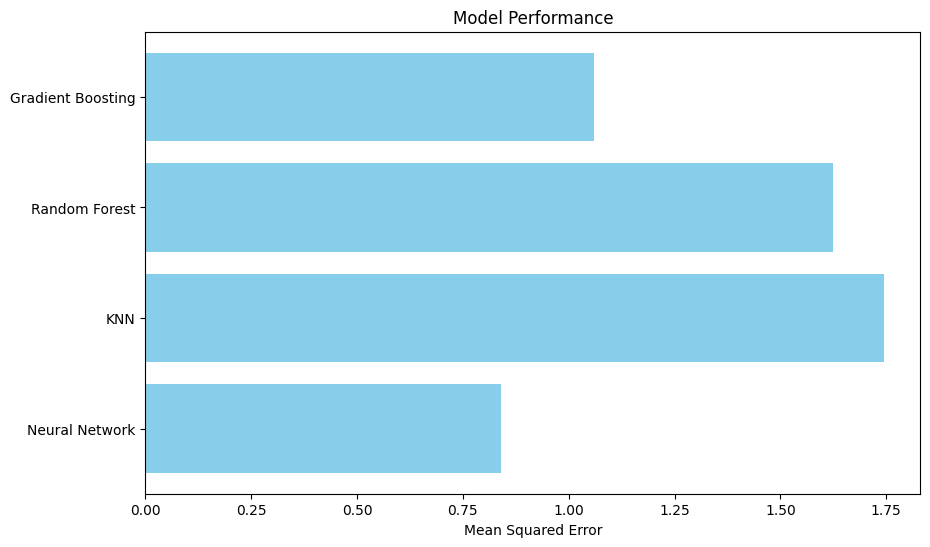

In [30]:
# Results visualization for pIC50
plot_results(results_pic50)

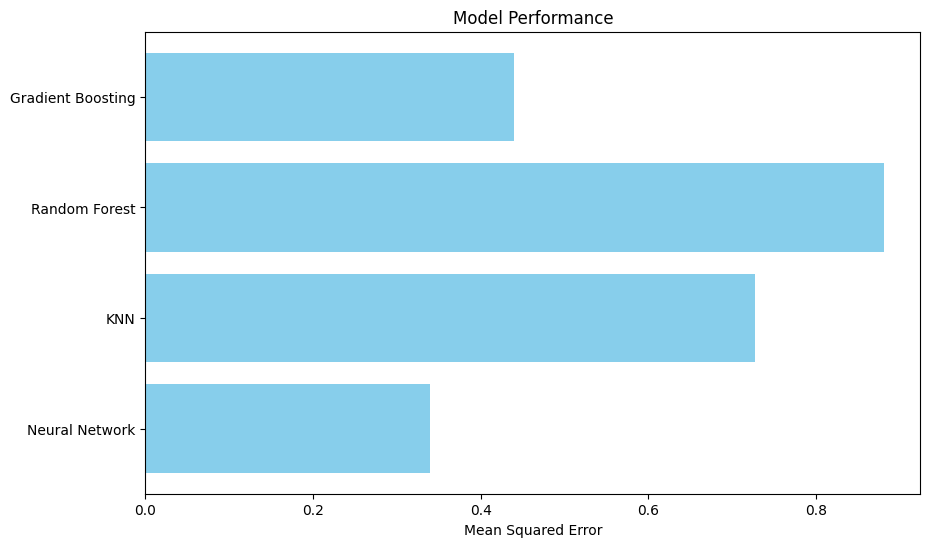

In [31]:
# Results visualization for logP
plot_results(results_logP)

In [33]:
# Visualize training processes for all models (pIC50)
# plot_multiple_training_processes(training_losses_pic50, validation_losses_pic50)


In [34]:
# Visualize training processes for all models (logP)
# plot_multiple_training_processes(training_losses_logP, validation_losses_logP)
